# Package

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision.models as models

import matplotlib.pyplot as plt
%matplotlib inline

# 构建数据集，将图片大小变为256*256
torch.manual_seed(24)
dataset = ImageFolder(root='./african-wildlife/', transform=transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()]))

# data process

In [3]:
# 查看数据集大小，有1504个图片
len(dataset)

1504

In [4]:
# 查看图片类别
classes = dataset.classes
classes

['buffalo', 'elephant', 'rhino', 'zebra']

In [5]:
# 60% 训练， 20%测试， 20%验证
temp_size = int(len(dataset)*0.4)
train_size = len(dataset) - temp_size

train_data, temp_data = random_split(dataset, [train_size, temp_size])
len(train_data), len(temp_data)

(903, 601)

In [6]:
val_size = int(len(temp_data)*0.5)
test_size = len(temp_data) - val_size

test_data, val_data = random_split(temp_data, [test_size, val_size])
len(test_data), len(val_data)

(301, 300)

In [7]:
# 构建数据加载器
batch_size = 16

train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size, num_workers=4, pin_memory=True)

images.shape: torch.Size([16, 3, 128, 128])


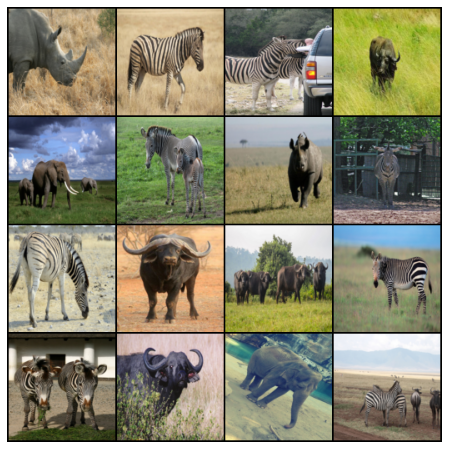

In [8]:
# 查看一个batch的数据
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=4).permute((1, 2, 0)))
    break

# build model

In [9]:
class CNNet(nn.Module):
    
    def __init__(self):
        super(CNNet,self).__init__()
        self.cnn =  nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride =1,padding=1),
                                  nn.BatchNorm2d(8),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),
                                  nn.MaxPool2d(2, 2),
                                 
                                  nn.Conv2d(16, 32, kernel_size=3, stride =1,padding=1),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(),
                                  nn.MaxPool2d(2, 2),
    
                                  nn.Flatten(),
                                  nn.Linear(16 * 16 * 16, 128),
                                  nn.LeakyReLU(),
                                  nn.Linear(128, 64),
                                  nn.LeakyReLU(),
                                  nn.Linear(64, 4))
        
    def forward(self, x):
        return self.cnn(x)
    

In [10]:
model = CNNet()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

CNNet(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 10

In [12]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

# model training

In [13]:

### Training Code

for epoch in range(epochs):
    
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_loader:
        model.train()
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)

     
    #Validation
    for images, labels in val_loader:
        model.eval()
        images = images.to(device)
        labels = labels.to(device)
        
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
     
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
    #Print Epoch Statistics
    print(f"Epoch {epoch}")
    print(f"Train Loss = {round(train_epoch_loss, 4)}")
    print(f"Train Accuracy = {train_epoch_accuracy} %")
    print(f"Val Loss = {round(val_epoch_loss, 4)}")
    print(f"Val Accuracy = {val_epoch_accuracy} %\n")
        

Epoch 0
Train Loss = 1.1698
Train Accuracy = 46.89849649122807 %
Val Loss = 0.9148
Val Accuracy = 58.991226315789476 %

Epoch 1
Train Loss = 0.755
Train Accuracy = 68.2800754385965 %
Val Loss = 0.8694
Val Accuracy = 62.7193 %

Epoch 2
Train Loss = 0.5868
Train Accuracy = 77.13032631578947 %
Val Loss = 0.8288
Val Accuracy = 63.1578947368421 %

Epoch 3
Train Loss = 0.4622
Train Accuracy = 83.19235614035087 %
Val Loss = 0.9538
Val Accuracy = 65.24122631578948 %

Epoch 4
Train Loss = 0.3707
Train Accuracy = 86.88909824561404 %
Val Loss = 1.2409
Val Accuracy = 58.88157894736842 %

Epoch 5
Train Loss = 0.2619
Train Accuracy = 91.55701754385964 %
Val Loss = 0.7904
Val Accuracy = 70.72368421052632 %

Epoch 6
Train Loss = 0.1517
Train Accuracy = 96.60087719298245 %
Val Loss = 0.885
Val Accuracy = 68.85964736842105 %

Epoch 7
Train Loss = 0.0856
Train Accuracy = 98.79385964912281 %
Val Loss = 0.8478
Val Accuracy = 69.1885947368421 %

Epoch 8
Train Loss = 0.0443
Train Accuracy = 99.67105263157895

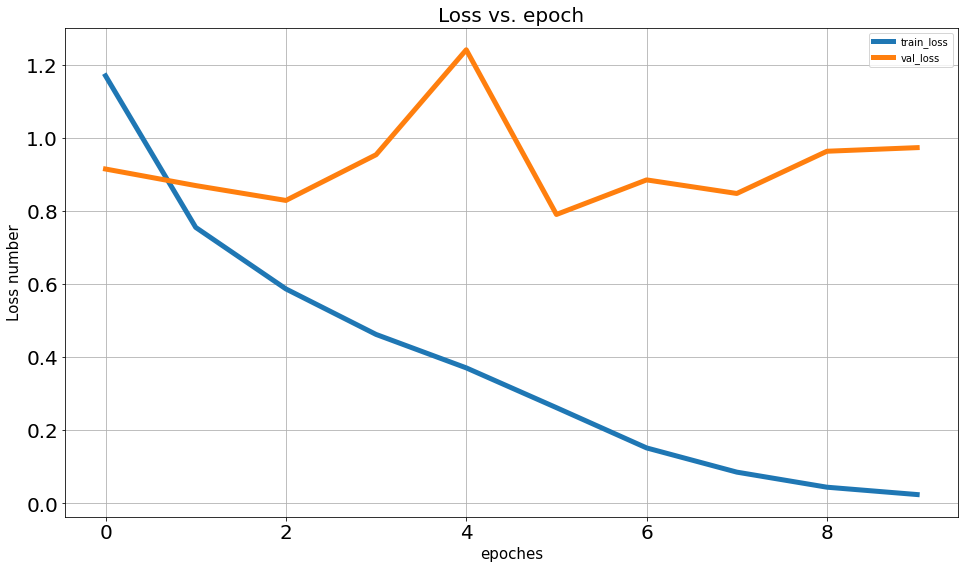

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax = plt.subplot(1, 1, 1)
ax.plot(train_loss,linewidth=5.0, label='train_loss')
ax.plot(val_loss,linewidth=5.0, label='val_loss')
ax.set_title('Loss vs. epoch', fontsize=20)
ax.set_ylabel('Loss number', fontsize=15)
ax.set_xlabel('epoches', fontsize=15)
ax.tick_params(labelsize=20)
plt.grid()
plt.legend()
plt.show()

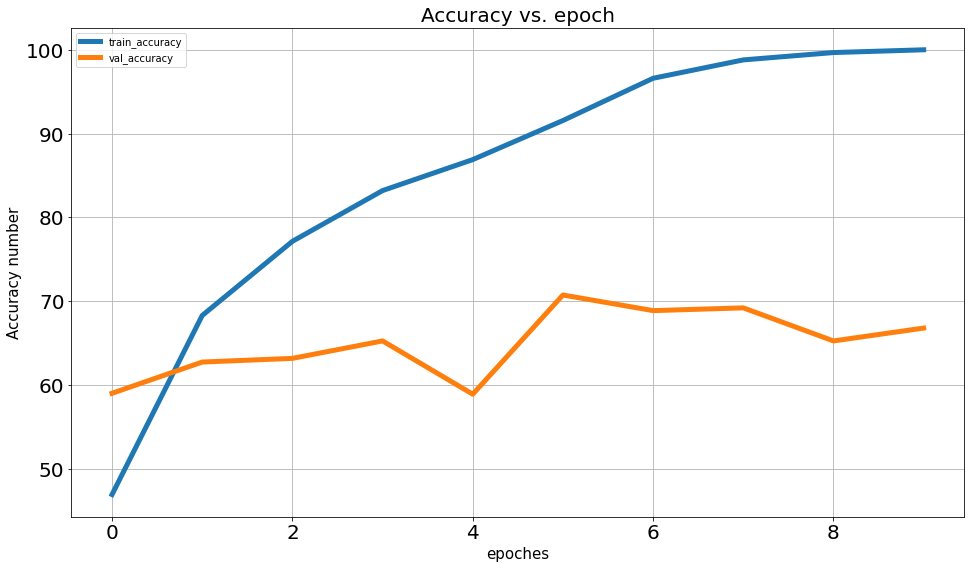

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
ax = plt.subplot(1, 1, 1)
ax.plot(train_accuracy,linewidth=5.0, label='train_accuracy')
ax.plot(val_accuracy,linewidth=5.0, label='val_accuracy')
ax.set_title('Accuracy vs. epoch', fontsize=20)
ax.set_ylabel('Accuracy number', fontsize=15)
ax.set_xlabel('epoches', fontsize=15)
ax.tick_params(labelsize=20)
plt.grid()
plt.legend()
plt.show()

In [16]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
cnn.0.weight 	 torch.Size([16, 3, 3, 3])
cnn.0.bias 	 torch.Size([16])
cnn.1.weight 	 torch.Size([16])
cnn.1.bias 	 torch.Size([16])
cnn.1.running_mean 	 torch.Size([16])
cnn.1.running_var 	 torch.Size([16])
cnn.1.num_batches_tracked 	 torch.Size([])
cnn.3.weight 	 torch.Size([32, 16, 3, 3])
cnn.3.bias 	 torch.Size([32])
cnn.4.weight 	 torch.Size([32])
cnn.4.bias 	 torch.Size([32])
cnn.4.running_mean 	 torch.Size([32])
cnn.4.running_var 	 torch.Size([32])
cnn.4.num_batches_tracked 	 torch.Size([])
cnn.7.weight 	 torch.Size([64, 32, 3, 3])
cnn.7.bias 	 torch.Size([64])
cnn.8.weight 	 torch.Size([64])
cnn.8.bias 	 torch.Size([64])
cnn.8.running_mean 	 torch.Size([64])
cnn.8.running_var 	 torch.Size([64])
cnn.8.num_batches_tracked 	 torch.Size([])
cnn.10.weight 	 torch.Size([32, 64, 3, 3])
cnn.10.bias 	 torch.Size([32])
cnn.11.weight 	 torch.Size([32])
cnn.11.bias 	 torch.Size([32])
cnn.11.running_mean 	 torch.Size([32])
cnn.11.running_var 	 torch.Size([32])
cnn.11.num

# save model

In [17]:
PATH = 'model_params.pkl'
torch.save(model.state_dict(), PATH)

In [18]:
model = CNNet()
model.load_state_dict(torch.load('./model_params.pkl'))
model.eval()

CNNet(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

# model predict

In [19]:
test_loss = 0
test_acc = 0
model.to(device)
for images, labels in test_loader:
        
    images = images.to(device)
    labels = labels.to(device)

    #Forward ->
    preds = model(images)

    #Calculate Accuracy
    acc = calc_accuracy(labels.cpu(), preds.cpu())

    #Calculate Loss
    loss = criterion(preds, labels)

    #Append loss & acc
    loss_value = loss.item()
    test_loss = loss_value
    test_acc = acc
    
print(f'Test accuracy = {test_acc} %')

Test accuracy = 61.5385 %


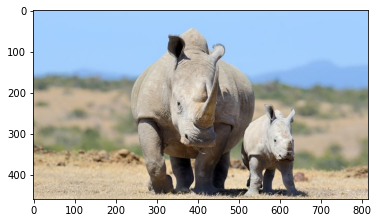

'rhino'

In [20]:
from PIL import Image
filename = '../input/african-wildlife/rhino/001.jpg'
input_image = Image.open(filename)
plt.imshow(input_image)
plt.show()
preprocess = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
with torch.no_grad():
    output = model(input_batch.to(device))

wildlife = {0:'buffalo', 1:'elephant', 2:'rhino', 3:'zebra'}
probabilities = F.softmax(output, dim=1)
wildlife[probabilities.argmax(-1).cpu().numpy()[0]]

In [21]:
filename = './model_params.pkl'
os.path.getsize(filename) / (1024 * 1024)

64.42794895172119

In [22]:
from IPython.display import FileLink

FileLink(filename)

/kaggle/working/model_params.pkl